# Superpixel Smapling Network and Deep Metric Learning

This is a demonstration of the algorithm to automatically generate a labeled image by first generating a superpixel reference dataset and second comparing the superpixels of the new image to be labeled with the refernece data by Deep Metric Learning Model)image.png

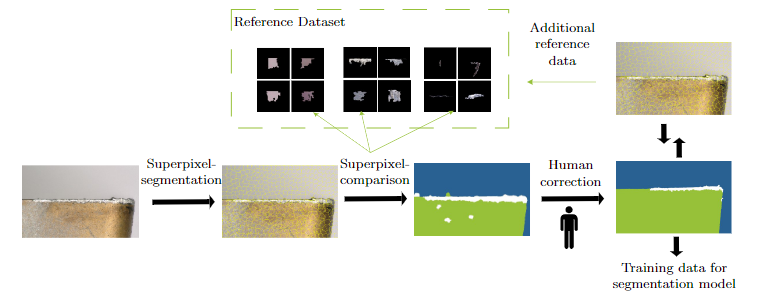

In [1]:
from IPython.display import Image
scheme = Image(filename='/home/ubuntu/deliverables/scheme.PNG',width=1000)    

display(scheme)

## Generate Superpixels with the Superpixel Sampling Network

In [1]:
img_path="/home/ubuntu/deliverables/images/3_haupt.png"
mask_path="/home/ubuntu/deliverables/images/3_haupt_mask.png"
img_inference_path="/home/ubuntu/deliverables/images/2_haupt.png"
weight_path_ssn=  "/home/ubuntu/deliverables/models/bset_model.pth"


In [6]:
import math
import numpy as np
import torch
import argparse
import os
import imutils
import cv2
import matplotlib.pyplot as plt
import matplotlib
from mask2metric import *
from logical_constraints import *

In [ ]:
from skimage.color import rgb2lab
from skimage.segmentation._slic import _enforce_label_connectivity_cython 
from skimage.segmentation import mark_boundaries
from Siamese.src.infer_siamese import main_siamese
from torchvision import datasets, transforms, models
from lib.ssn.ssn import sparse_ssn_iter


In [4]:

### Function that runs Superpixel Sampling Network
@torch.no_grad()
def inference(image, nspix, n_iter, fdim=None, color_scale=0.26, pos_scale=2.5, weight=None, enforce_connectivity=True):
 
    if weight is not None:
        from model import SSNModel
        model = SSNModel(fdim, nspix, n_iter).to("cuda")
        checkpoint = torch.load(weight)
        model.load_state_dict(checkpoint)
        model.eval()
    else:
        model = lambda data: sparse_ssn_iter(data, nspix, n_iter)

    height, width = image.shape[:2]

    nspix_per_axis = int(math.sqrt(nspix))
    pos_scale = pos_scale * max(nspix_per_axis/height, nspix_per_axis/width)    

    coords = torch.stack(torch.meshgrid(torch.arange(height, device="cuda"), torch.arange(width, device="cuda")), 0)
    coords = coords[None].float()

    image = rgb2lab(image)
    image = torch.from_numpy(image).permute(2, 0, 1)[None].to("cuda").float()

    inputs = torch.cat([color_scale*image, pos_scale*coords], 1)

    _, H, _ = model(inputs)

    labels = H.reshape(height, width).to("cpu").detach().numpy()

    if enforce_connectivity:
        segment_size = height * width / nspix
        min_size = int(0.02 * segment_size)   #0.06
        max_size = int(3 * segment_size)    #3
        labels = _enforce_label_connectivity_cython(
            labels[None], min_size, max_size)[0]

    return labels

##Function to set parameters of Superpixel Sampling Network
def ssn_generate(path):
    
    import time
    import argparse
    import matplotlib.pyplot as plt
    from skimage.segmentation import mark_boundaries
    from skimage import color
  
    """
      Args:
        image: numpy.ndarray
            An array of shape (h, w, c)
        nspix: int
            number of superpixels
        n_iter: int
            number of iterations
        fdim (optional): int
            feature dimension for supervised setting
        color_scale: float
            color channel factor
        pos_scale: float
            pixel coordinate factor
        weight: state_dict
            pretrained weight
        enforce_connectivity: bool
            if True, enforce superpixel connectivity in postprocessing
    """

    nspix=400
    fdim=20
    niter=50
    color_scale=0.26
    pos_scale=2.5
 

    image = cv2.imread(path)
   
    s = time.time()
    label = inference(image, nspix,niter, fdim,color_scale, pos_scale,weight_path_ssn)

    return label


image = cv2.imread(img_path)
segments = ssn_generate(img_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imsave("/home/ubuntu/deliverables/images/ssn.png",mark_boundaries(image, segments))
  
    

/home/ubuntu/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Display of the original image and the the marked Superpixels

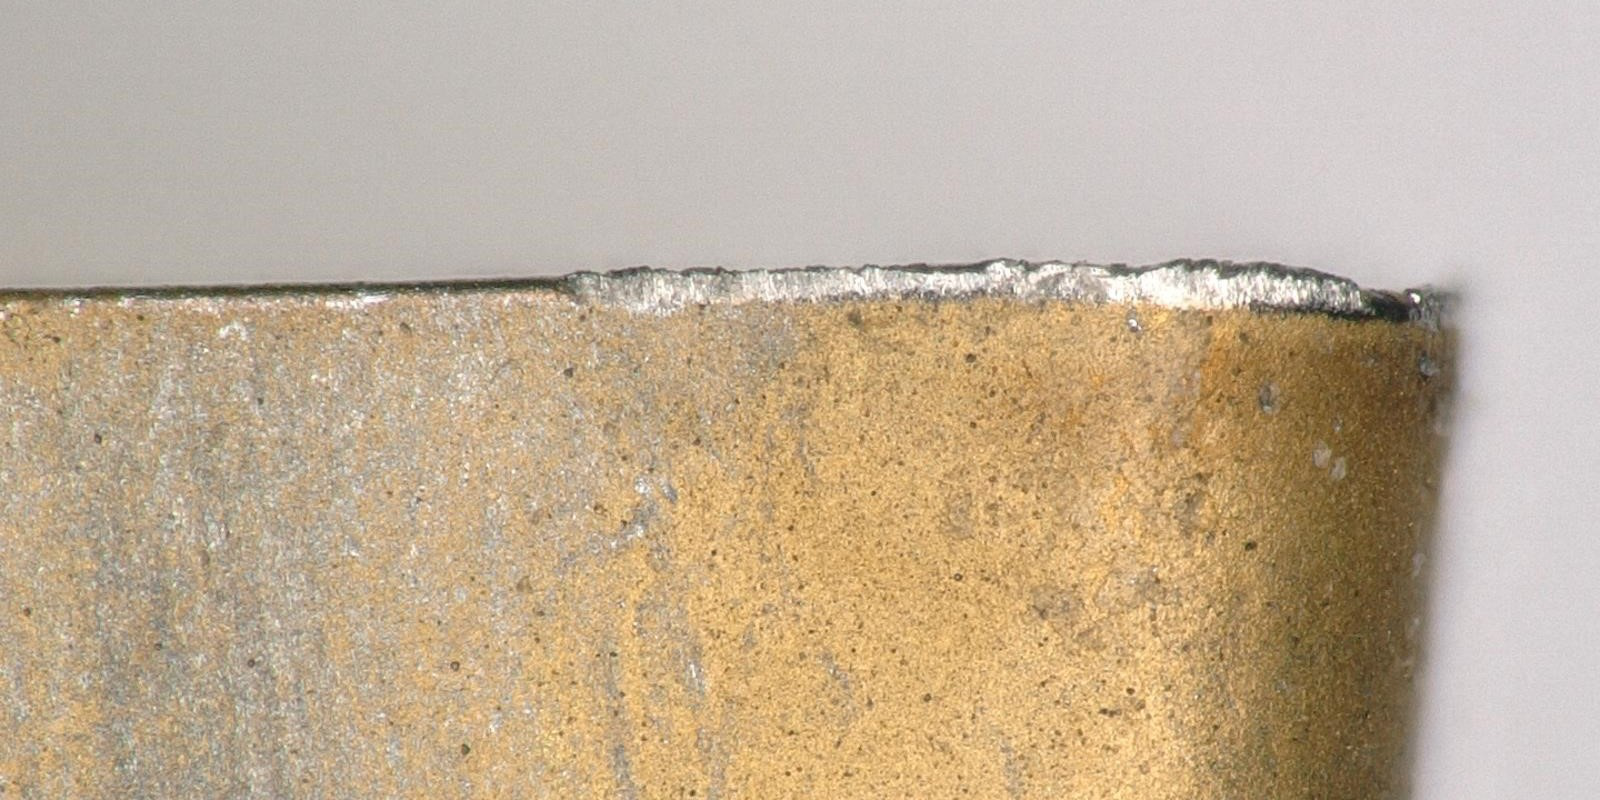

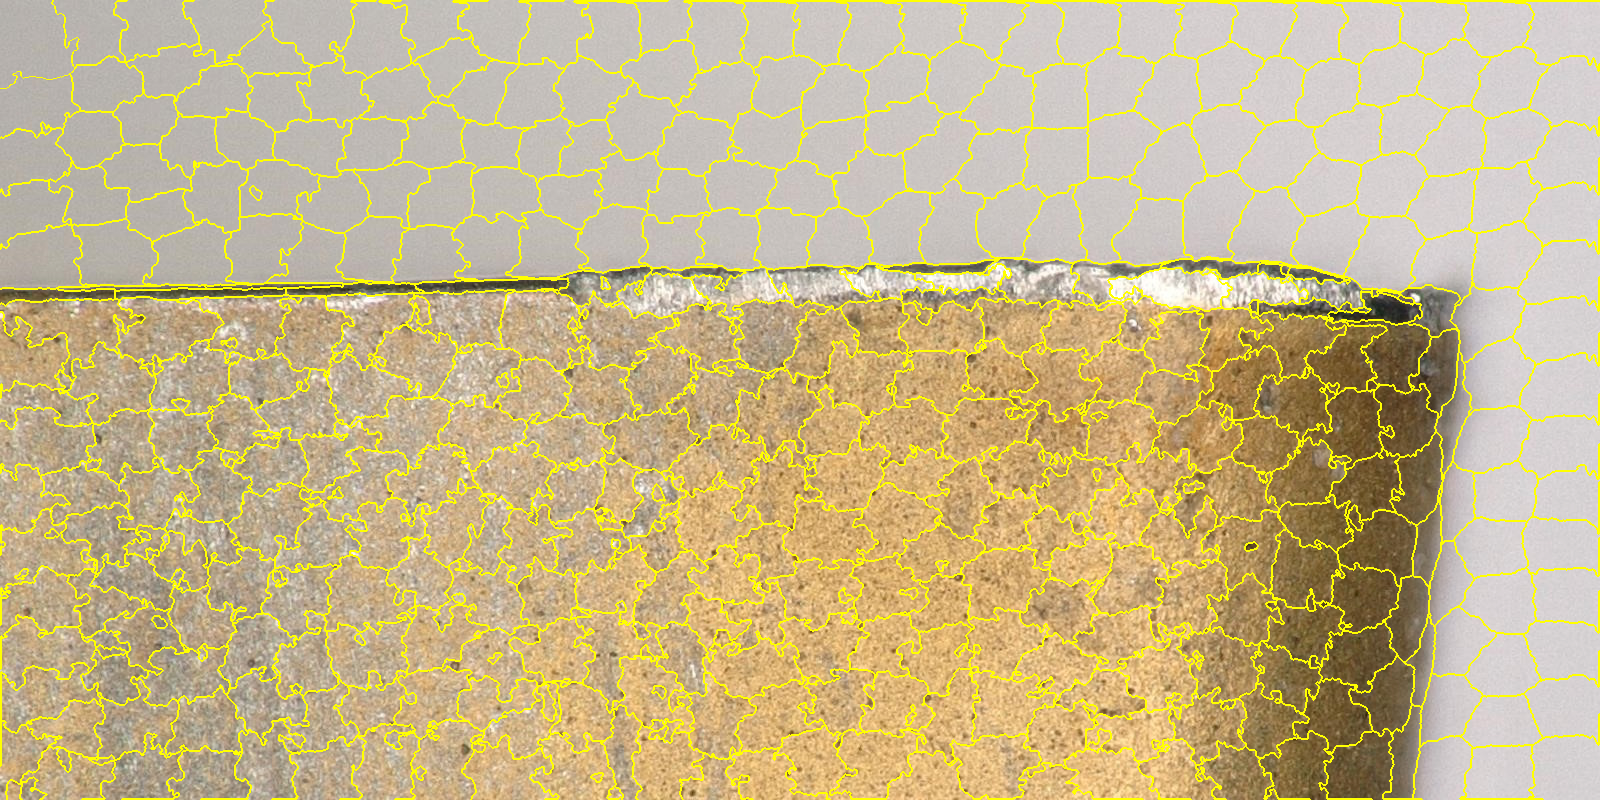

In [1]:
from IPython.display import Image
image2 = Image(filename='/home/ubuntu/deliverables/images/ssn.png',width=600)    
image1 = Image(filename='/home/ubuntu/deliverables/images/3_haupt.png',width=600)  
display(image1,image2)

### Superpixels are getting saved according to their class

In [6]:

height, width, channels = image.shape
image = cv2.imread(img_path)
mask =  cv2.imread(mask_path)
image_nr = os.path.basename(img_path)
h, w, c = image.shape

segments = ssn_generate(img_path)


categories = ["Background" , "Tool", "Wear"]
colors = ["#000000","#ff0505","#ffffff"]

for category in categories:
    name = category
    if not os.path.exists("metric/reference/"):
                os.mkdir("metric/reference/")
    if not os.path.exists("metric/reference/"+name):
                os.mkdir("metric/reference/"+name)


for i in range(0,(len(np.unique(segments)))):

    u,v=np.where(segments==i)

    leftmost = np.min(u)
    rightmost = np.max(u)
    topmost = np.min(v)
    bottommost = np.max(v)
    
    segment = image.copy()
    segment[segments!=i] = 0
    
    horizontal = rightmost- leftmost
    vertikal = bottommost-topmost

    if (vertikal<224):
        restv = 224 - vertikal
    else:
        restv=0
    if (horizontal<224):
        resth = 224 - horizontal
    else:
        resth = 0

    centerhorizontal = leftmost + int(horizontal/2)
    centervertical = topmost + int(vertikal/2)
    r,g,b = mask[centerhorizontal,centervertical]
    hex_color = matplotlib.colors.to_hex([(b/255), (g/255), (r/255) ])
    hex_color_close = matplotlib.colors.to_hex([(b/255), (g/255), ((r)/255) ])
   
    cleftmost = leftmost - int(resth/2)
    crightmost = rightmost + int(resth/2)
    cbottommost = bottommost + int(restv/2)
    ctopmost = topmost - int(restv/2)

    if (cleftmost>=1 and crightmost<=w and ctopmost>=1 and cbottommost<=h):        
        crop_img = segment[cleftmost:crightmost,ctopmost:cbottommost]   
        j=0
        for cat in categories:
            
            if (hex_color == colors[j] ):  
                cv2.imwrite(('metric/reference/'+cat+"/"+image_nr+str(i)+'.png'),crop_img)
            j+=1   
        
    else:
        if (vertikal<224):
            restv = 224 - vertikal
        else:
            restv=0
        if (horizontal<224):
            resth = 224 - horizontal
        else:
            resth = 0
        crop_img = segment[leftmost:rightmost, topmost:bottommost] 
        crop_img = cv2.copyMakeBorder(crop_img, int(resth/2), int(resth/2), int(restv/2), int(restv/2), cv2.BORDER_CONSTANT, value=[0, 0, 0])   
        j=0
        for cat in categories:
            if (hex_color == colors[j]  ):  
                cv2.imwrite(('metric/reference/'+cat+"/"+image_nr+str(i)+'_edge.png'),crop_img)
            j += 1



Exemplary saved Superpixel

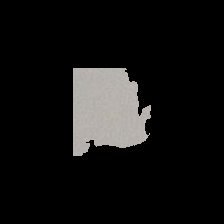

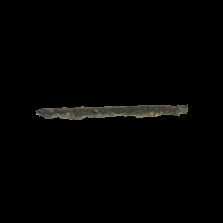

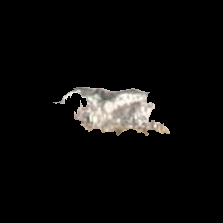

In [3]:
from IPython.display import Image

image1 = Image(filename='/home/ubuntu/deliverables/metric/reference/Background/3_haupt.png0_edge.png') 
image2 = Image(filename='/home/ubuntu/deliverables/metric/reference/Tool/3_haupt.png154.png')
image3 = Image(filename='/home/ubuntu/deliverables/metric/reference/Wear/3_haupt.png134_edge.png')

display(image1,image2,image3)

## Automatically label new image by Deep Metric Learning

In [8]:

categories = ["Background" , "Tool", "Wear"]
colors = ["#000000","#ff0505","#ffffff"]

from Siamese.src.infer_siamese import main_siamese
image_inference = cv2.imread(img_inference_path)
h, w, c = image_inference.shape

ssn_generate(img_inference_path)
segments = ssn_generate(img_inference_path)
 
segment = image_inference.copy()
image_vec = []
seg_num = len(np.unique(segments))

for i in range(0,seg_num):
    u,v=np.where(segments==i)
    leftmost = np.min(u)
    rightmost = np.max(u)
    topmost = np.min(v)
    bottommost = np.max(v)
    
    segment = image_inference.copy()
    segment[segments!=i] = 0
    
    horizontal = rightmost- leftmost
    vertikal = bottommost-topmost

    if (vertikal<224):
        restv = 224 - vertikal
    else:
        restv=0
    if (horizontal<224):
        resth = 224 - horizontal
    else:
        resth = 0
    
    cleftmost = leftmost - int(resth/2)
    crightmost = rightmost + int(resth/2)
    cbottommost = bottommost + int(restv/2)
    ctopmost = topmost - int(restv/2)

    if (cleftmost>=1 and crightmost<=w and ctopmost>=1 and cbottommost<=h):        
        crop_img = segment[cleftmost:crightmost,ctopmost:cbottommost]
    else:
        if (vertikal<224):
            restv = 224 - vertikal
        else:
            restv=0
        if (horizontal<224):
            resth = 224 - horizontal
        else:
            resth = 0
        crop_img = segment[leftmost:rightmost, topmost:bottommost] 
        crop_img = cv2.copyMakeBorder(crop_img, int(resth/2), int(resth/2), int(restv/2), int(restv/2), cv2.BORDER_CONSTANT, value=[0, 0, 0])         
    
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    

    to_pil = transforms.ToPILImage()
    imagee = transforms.ToPILImage()(crop_img)
    image_vec.append(imagee)
            
distance, paths = main_siamese(image_vec)

k = 0

for path in paths:        

    header = []
    dinstances = distance[k]
    first_distance = dinstances[0]
    if (first_distance <=0.08):
        
        for u in range(0,5):
            head, tail = os.path.split(path[u])
            header.append(head)
        
        first_path = header[0]
        folders = first_path.split('/')
        print(folders)
        p = folders.index("reference")
        class_name = folders[p+1]
        print(class_name.split('_')[0])
        class_name = class_name.split('_')[0]
        j=0
        for cat in categories:
            if(class_name == cat):
                color = np.array((matplotlib.colors.to_rgb(colors[j])))*255
                color = np.flip(color)
                image_inference[segments==k] =  color.astype(int)
            j+=1

    k=k+1 

mask_colored = cv2.cvtColor(image_inference, cv2.COLOR_BGR2RGB)

plt.imsave( ("images/"  + os.path.basename(img_inference_path)+"_mask.png"),mask_colored)   
 


22-Oct-06 11:32:30  root  INFO: Initialized device cuda
22-Oct-06 11:32:30  root  INFO: Loaded checkpoint at 'checkpoint_path']
22-Oct-06 11:32:30  root  INFO: Loaded config: {'batch_size': 24,
 'embedding_size': 128,
 'gamma': 0.1,
 'image_size': 448,
 'lambda': 20,
 'lr': 0.0001,
 'margin': 0.01,
 'n_centers_per_class': 5,
 'pretrained': True,
 'tau': 0.0}
22-Oct-06 11:32:31  root  INFO: Initialized model: Resnet50(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

Automatically generated Mask

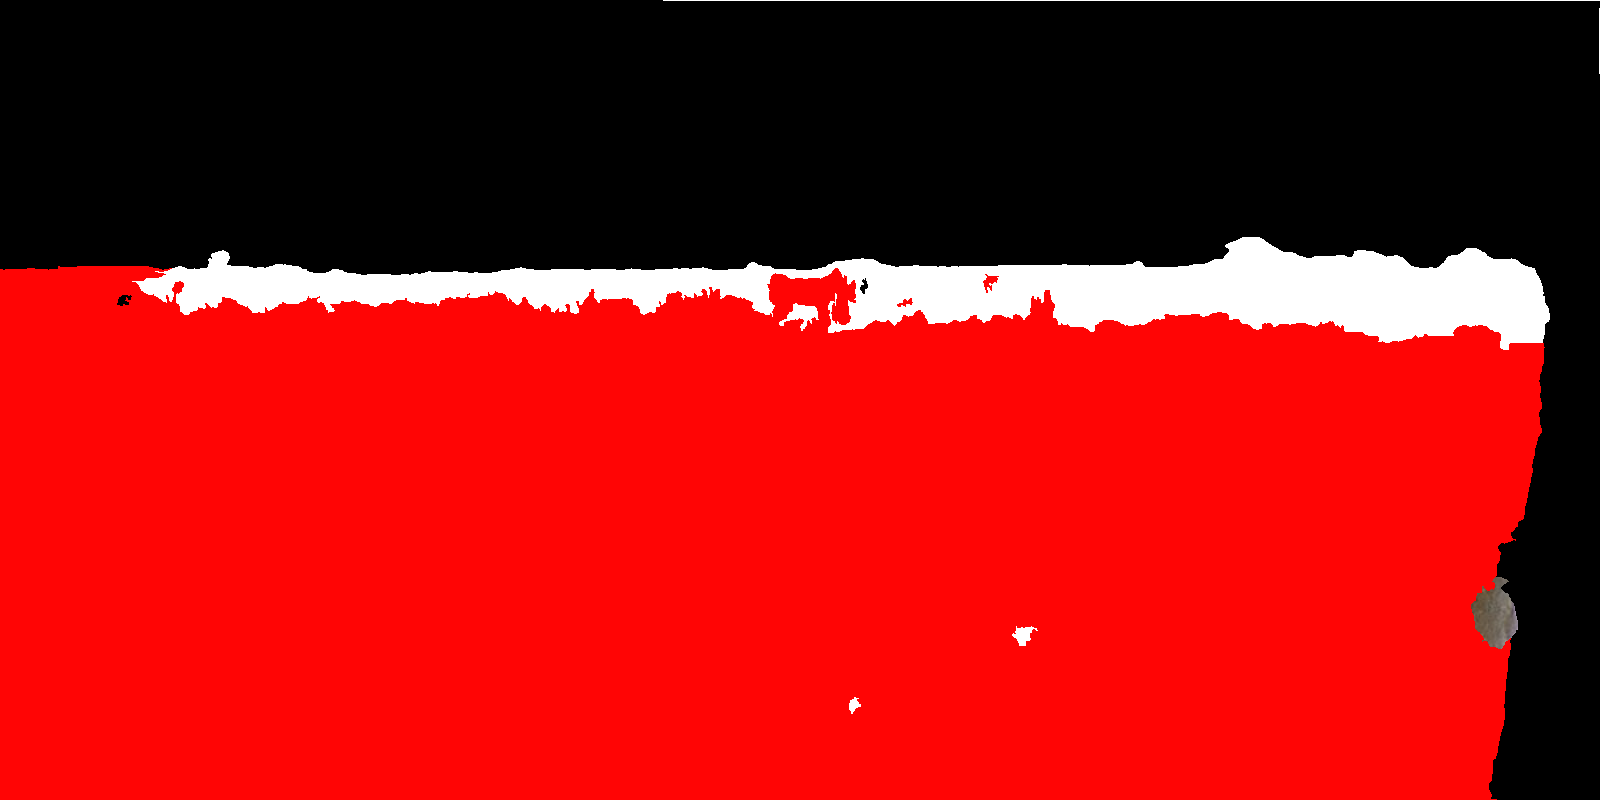

In [9]:
from IPython.display import Image
Image(filename='/home/ubuntu/deliverables/images/2_haupt.png_mask.png',width=700)    


In [4]:
mask =  cv2.imread('/home/ubuntu/deliverables/images/2_haupt.png_mask.png')
mask = correct_red(mask)    ## corrects faulty red (tool) superpixels that are completely spourrounded by black superpixels
mask = correct_black(mask)  ## corrects faulty black (background) superpixels that are completely spourrounded by red or white superpixels
mask = correct_white(mask)  ## corrects faulty white (wear) superpixels that are completely spourrounded by black or red superpixels (red superpixels sourrounding is actually possible to be right)
cv2.imwrite(('/home/ubuntu/deliverables/images/mask_corrected.png'),mask)


NameError: name 'cv2' is not defined

In [1]:
mask =  cv2.imread('/home/ubuntu/deliverables/images/mask_corrected.png')
CONVERSION_FACTOR =  0.200 / 198  #198 px are 0.1 mm
metrics = analyze_mask(mask, CONVERSION_FACTOR)
print(metrics)

NameError: name 'cv2' is not defined